In [1]:
import numpy as np
import pandas as pd
import os

In [ ]:
#NOTE: for LGD, EAD model, we don't care about weight of evidence. for discrete variables, We can simply create as many dummy variables as there are categories. And for continuous variables, can use them as they are, or transform them if 

# import data

In [2]:
path_datamart = r'C:\Users\DDD\Google Drive\Coding\Python\Credit Risk Modeling in Python\Datamart'
loan_data_preprocessed = pd.read_csv(os.path.join(path_datamart, 'loan_data_2007_2014_preprocessed.csv'), index_col=0)  # used the preprocessed data like what we have processed in the Data Prep notebook. However, for all population.
loan_data_preprocessed_backup = loan_data_preprocessed.copy()

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# to compute LGD, EAD, need to allow sometimes for the customer to repay the owed amount. Plus, the lender could also take some action (sell house) to recover part of the debt --> only compute for those accounts that have been written off --> loan_status = Charged Off + Does not meet the credit policy.
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin([
    'Charged Off',
    'Does not meet the credit policy. Status:Charged Off'
])]

In [6]:
print(loan_data_preprocessed.shape)
print(loan_data_defaults.shape)

(466285, 208)
(43236, 208)


# independent variable

In [9]:
pd.options.display.max_rows = None

In [10]:
loan_data_defaults.isnull().sum()       # count number of null rows in each variable
#NOTE: in any other occassion, have to consider whether imputing the variable is appropriate. In this current situation, it is sufficient to just impute missing values for Mths_since_last_delinq and Mths_since_last_record to be zero. 

Unnamed: 0.1                                                           0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                     

In [ ]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace=True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

# dependent variable

## LGD = 1 - Recovery rate

In [13]:
# For LGD, usually work with recovery rate --> then derive LGD.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

<ipython-input-13-5ed9733f8333>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [14]:
# since the max value of recovery rate is higher than 100% --> does not make sense --> adjust the recovery rate for extreme cases
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

<ipython-input-14-d967ec590e58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
<ipython-input-14-d967ec590e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

## EAD = total funded amount * credit conversion factor

In [15]:
# CCF = credit conversion factor = proportion of total exposure, at moment of default = what is remained in the principal, after deducting all of the principal payment the borrower has made. Expressed as % of funded amount
# CCF = 0 if all principal has been paid. = 1 if nothing has been paid
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

<ipython-input-15-b439f0bd160c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']


count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [16]:
loan_data_defaults.to_csv(os.path.join(path_datamart, 'loan_data_defaults.csv'))

## visualise

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

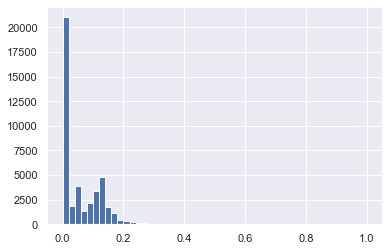

In [18]:
plt.hist(loan_data_defaults['recovery_rate'], bins=50)      # plot histogram recovery rate

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

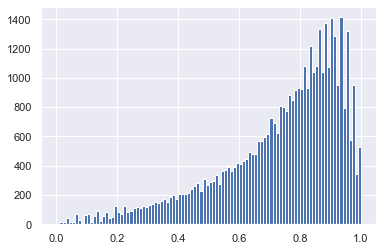

In [20]:
plt.hist(loan_data_defaults['CCF'], bins=100)      # plot histogram credit conversion factor

## procedure

In [ ]:
#NOTE: The 2 LGD and EAD are constrained between 0 and 1 --> best described as Beta distribution --> but python does not have a package to regress Beta yet. Although R has. In this case, we will use logistic and linear regression

# LGD:
# 50% of the population has Recovery Rate of 0 --> create a boolean, to check if the Recovery Rate is 0, Logistic Regression. 
# if Recovery Rate is other than 0 --> use Linear Regression to estimate recovery rate. 

# CCF: 
# can use Linear Regression model